In [1]:
# pip install ipywidgets

In [4]:
import warnings
warnings.filterwarnings("ignore")

#  Darts

darts is a Python library for easy manipulation and forecasting of time series.

It contains a variety of models, from classics such as ARIMA to deep neural networks.

The models can all be used in the same way, using fit() and predict() functions, similar to scikit-learn. 

Darts supports both univariate and multivariate time series and models. 


In [5]:
import pandas as pd
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

import matplotlib.pyplot as plt
series= AirPassengersDataset().load()
df_series=series.pd_dataframe()
df_series

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


#  Data processing using Darts

In [6]:
from darts.dataprocessing.transformers import Scaler
scaler_air= Scaler()
series = scaler_air.fit_transform(series)

#  Models using Darts

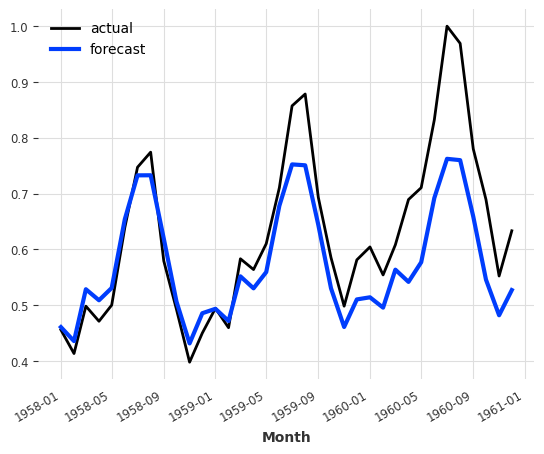

In [7]:
from darts.models import ExponentialSmoothing,ARIMA,AutoARIMA
import matplotlib.pyplot as plt

train, val = series.split_before(pd.Timestamp('19580101'))

model = ARIMA()
model.fit(train)
prediction = model.predict(len(val))



val.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

# Covariate time series

### time series which may help in the forecasting of the target series, but that we are not interested in forecasting. It's sometimes also called external data.


### We further differentiate covariates series, depending on whether they can be known in advance or not:

## Past Covariates :-

### time series whose past values are known at prediction time. These are usually things that have to be measured or observed.

## Future Covariates :-

###   time series whose future values are already known at prediction time for the span of the forecast horizon. These can for instance represent known future holidays, or weather forecasts.

# River Flow Forecasting Problem

#   Generating Fake Data
We start by generating some fake (toy) data to create a problem instance. We'll use daily time steps.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from darts.utils import timeseries_generation as tg

np.random.seed(42)

LENGTH = 3 * 365  # 3 years of daily data

# Melting: a sine with yearly periodicity and additive white noise
melting = (0.9 * tg.sine_timeseries(length=LENGTH, value_frequency=(1/365), 
                              freq='D', 
                              column_name='melting')
           + 0.1 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# Rainfalls: a sine with bi-weekly periodicity and additive white noise
rainfalls = (0.5 * tg.sine_timeseries(length=LENGTH, 
                                value_frequency=(1/14), 
                                freq='D', 
                                column_name='rainfall')
             + 0.5 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# We shift the melting by 5 days
melting_contribution = 0.5 * melting.shift(5)

# We compute similar contribution from the rainfalls
all_contributions = [melting_contribution] + [0.1 * rainfalls.shift(lag) for lag in range(5)]

# We compute the final flow as the sum of everything; trimming series so they
# all have the same start time
flow = sum([series[melting_contribution.start_time():][:melting.end_time()]
            for series in all_contributions]).with_columns_renamed('melting', 'flow')

# add some white noise
flow += 0.1 * tg.gaussian_timeseries(length=len(flow))

# plt.figure(figsize=(12,5))
# melting.plot()
# rainfalls.plot()
# flow.plot(lw=4)

flow_df=flow.pd_dataframe()
rainfall_df=rainfalls.pd_dataframe()
meting_df=melting.pd_dataframe()

merged_df=rainfall_df.merge(meting_df,on='time').merge(flow_df,on='time')
merged_df

component,rainfall,melting,flow
time,,,
2000-01-06,0.889921,0.053955,0.079456
2000-01-07,-1.231186,0.250713,0.112739
2000-01-08,1.044187,0.184931,0.481231
2000-01-09,-0.286737,0.076603,0.070752
2000-01-10,0.163176,0.193134,0.096160
...,...,...,...
2002-12-26,0.375801,-0.084528,-0.109577
2002-12-27,-0.928920,-0.065644,-0.143771
2002-12-28,-0.133326,0.026305,-0.244494


#  Model Evaluation

In [12]:
from darts.metrics import rmse

# We first set aside the first 80% as training series:
flow_train, _ = flow.split_before(0.8)

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=flow, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=10)
    
    flow[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(flow, backtest)))

#   build a first model that does not use covariates.

2022-11-04 10:15:37 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-04 10:15:37 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-04 10:15:37 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-04 10:15:37 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-04 10:15:37 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

2022-11-04 10:16:34 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


  0%|          | 0/210 [00:00<?, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Backtest RMSE = 0.18909410151084138


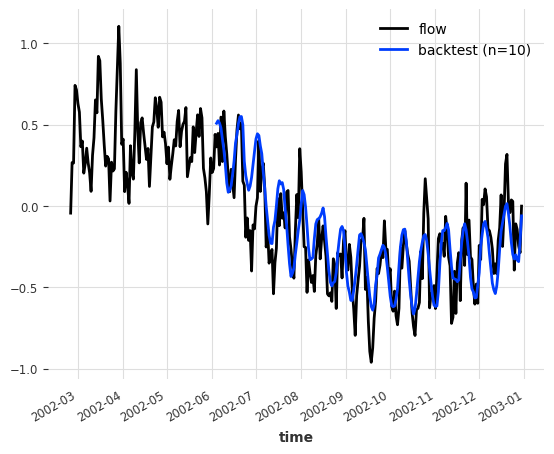

In [13]:
from darts.models import BlockRNNModel

brnn_no_cov = BlockRNNModel(input_chunk_length=30, 
                            output_chunk_length=10, 
                            n_rnn_layers=2)

brnn_no_cov.fit(flow_train, 
                epochs=100, 
                verbose=True)

eval_model(brnn_no_cov)

#   Using Past covariates

### using meliting as past covariates

2022-11-04 10:17:27 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-04 10:17:27 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-04 10:17:27 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-04 10:17:27 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-04 10:17:27 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

2022-11-04 10:18:39 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


  0%|          | 0/210 [00:00<?, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Backtest RMSE = 0.17002959406310414


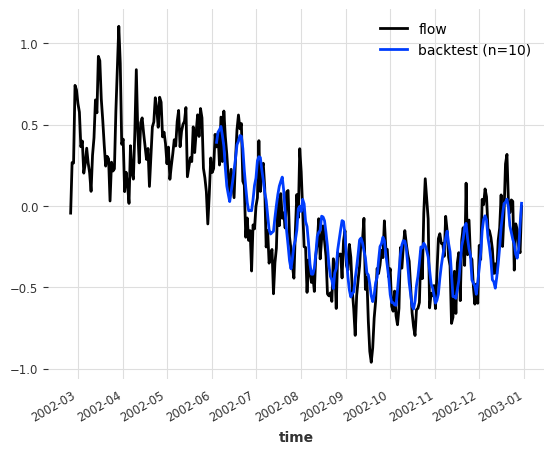

In [14]:
brnn_melting = BlockRNNModel(input_chunk_length=30, 
                             output_chunk_length=10, 
                             n_rnn_layers=2)

brnn_melting.fit(flow_train, 
                 past_covariates=melting, 
                 epochs=100, 
                 verbose=True)

eval_model(brnn_melting, 
           past_covariates=melting)

#  future covariates (rainfall)

2022-11-02 13:53:01 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-11-02 13:53:01 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-02 13:53:01 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-02 13:53:01 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-02 13:53:01 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

2022-11-02 13:54:22 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


  0%|          | 0/210 [00:00<?, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

Backtest RMSE = 0.17155090332236964


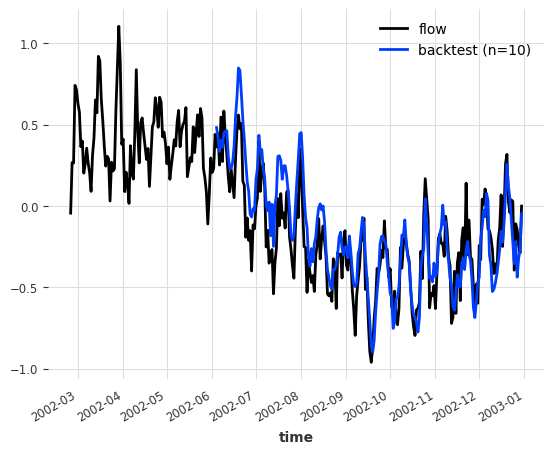

In [6]:
from darts.models import RNNModel

rnn_rain = RNNModel(input_chunk_length=30, 
                    training_length=40, 
                    n_rnn_layers=2)

rnn_rain.fit(flow_train, 
             future_covariates=rainfalls, 
             epochs=100, 
             verbose=True)

eval_model(rnn_rain, 
           future_covariates=rainfalls)

# Using Both Past and Future Covariates at the same time

# 

  0%|          | 0/210 [00:00<?, ?it/s]

Backtest RMSE = 0.10187514936430653


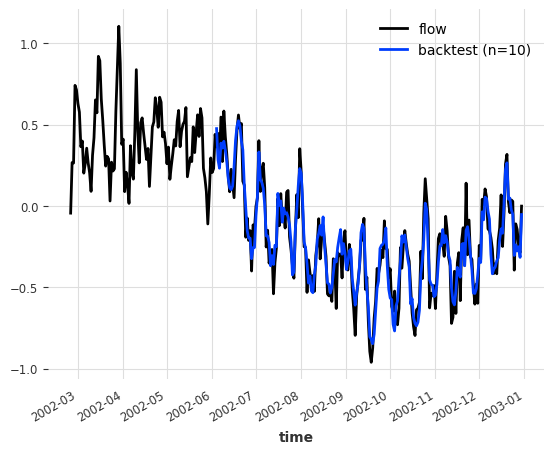

In [7]:
from darts.models import RegressionModel

regr_model = RegressionModel(lags=None,
                             lags_past_covariates=[-5, -4, -3, -2, -1], 
                             lags_future_covariates=[-4, -3, -2, -1, 0])

regr_model.fit(flow_train,
               past_covariates=melting,
               future_covariates=rainfalls)

eval_model(regr_model)